In [1]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "dask",
#     "h5netcdf",
#     "matplotlib",
#     "netcdf4",
#     "obstore",
#     "rasterio",
#     "rioxarray",
#     "s3fs",
#     "xarray",
# ]
# ///

# Cloud-native access of GOES netCDF files in S3

**Author**: Henry Rodman

**Date**: June 16, 2025

**Objective**: The GOES dataset is stored in netCDF-4 format in S3 and users want to know the best way to access these files in a cloud-native way (i.e. without managing downloads, performing efficient targeted read operations).

This notebook demonstrates how to perform targeted spatial reads of the files directly from S3 (without manually managing file downloads) to create a datacube that can be analyzed. Since the GOES netCDF files contain dozens of variables, I also want to increase efficiency by only reading data for a specific set of variables.

**The most efficient method I tested was to use GDAL's NETCDF driver** and `rioxarray.open_rasterio`, but with some careful tuning of the `fsspec` and `open_mfdataset` parameters the `xarray.open_mfdataset` method is also fairly efficient (although it downloads more data).

The GDAL method adds some additional complexity up front because you need to write more manual xarray concatenation code, but it is the most surgical method for reading small subsets of these netCDF files. Using `fsspec` and `xarray.open_mfdataset` is also a viable option but it will download the entire contents of the netCDF files in the process.

In [ ]:
# install dependencies
# %pip install fsspec numpy obstore rasterio rioxarray xarray

In [76]:
import json

import fsspec
import numpy as np
import obstore
import rasterio
import rasterio.windows
import rioxarray
import xarray as xr
from obstore.store import from_url
from rasterio.transform import rowcol
from rasterio.warp import transform_bounds

bucket = "noaa-goes16"

# list of variables of interest
variables = [
    "CMI_C08", "CMI_C10", "CMI_C13", "CMI_C15", "DQF_C08", "DQF_C10", "DQF_C13", "DQF_C15"
]

# example AOI (bbox) in GOES coordinates
# TODO: explain how to go from a lat/lon bounding box to these coordinates!
x0, x1 = 3600, 5000
y0, y1 = 1200, 2500

In [ ]:
goes_store = from_url(
    f"s3://{bucket}/",
    region="us-east-1",
    skip_signature=True,
)

product = "ABI-L2-MCMIPF"
year = "2019"
doy = "269"
hour = "12"

stream = obstore.list(
    goes_store,
    prefix=f"{product}/{year}/{doy}/{hour}/",
    chunk_size=10,
)

goes_keys = [
    obj["path"]
    for batch in stream
    for obj in batch
]

print(goes_keys)

## Using GDAL's NETCDF driver

GDAL provides a way to access individual variables (subdatasets) from NetCDF files using this path pattern: `NETCDF:"/path/to/file.nc":{subdataset_name}`.

When combined with the `/vsis3` driver this pattern allows efficient access to individual layers within the NetCDF files directly from S3.

This method requires doing more manual work to calculate the correct time coordinate for a given file and to apply the scale and offset to the raw values, but it is the most *efficient* method that I identified for reading small subsets of the GOES netCDF files.

In [78]:
# create the dataset URIs using the NetCDF and /vsis3 syntax
def create_vsi_uri(bucket: str, key: str, variable: str) -> str:
    return f'NETCDF:"/vsis3/{bucket}/{key}":{variable}'

sample_uri = create_vsi_uri(bucket, goes_keys[0], variables[0])
sample_uri

'NETCDF:"/vsis3/noaa-goes16/ABI-L2-MCMIPF/2019/269/12/OR_ABI-L2-MCMIPF-M6_G16_s20192691200244_e20192691209558_c20192691210065.nc":CMI_C08'

Use `rasterio` to load some metadata about one of the variable layers to learn more about the data structure.

In [79]:
with rasterio.Env(AWS_NO_SIGN_REQUEST=True):
    with rasterio.open(sample_uri) as src:
        profile = src.profile

print(profile)

{'driver': 'netCDF', 'dtype': 'uint16', 'nodata': 65535.0, 'width': 5424, 'height': 5424, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["unknown",DATUM["unnamed",SPHEROID["Spheroid",6378137,298.2572221]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Geostationary_Satellite"],PARAMETER["central_meridian",-75],PARAMETER["satellite_height",35786023],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=geos +lon_0=-75 +h=35786023 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs +sweep=x"]]'), 'transform': Affine(2004.017315487541, 0.0, -5434894.700982174,
       0.0, -2004.017315487541, 5434894.700982174), 'blockxsize': 226, 'blockysize': 226, 'tiled': True}


One important insight about these files is that the `blockxsize` and `blockysize` attributes are set to `256` - which means we should be able to perform targeted reads based on our spatial area of interest rather than loading all of the bytes then subsetting down to a smaller window.

We can use `rioxarray.open_rasterio` and some xarray concatenation to create an `xarray.Dataset` with a time dimension (`t`) to match the `xr.open_mfdataset` result. We also need to apply the scale and offset to the data values in order to represent each variable in its native units.

In [82]:
%%time
with rasterio.Env(AWS_NO_SIGN_REQUEST=True):
    arrays = {}
    for variable in variables:
        arrs = []
        for key in goes_keys:
            uri = create_vsi_uri(bucket, key, variable)
            _arr = (
                rioxarray.open_rasterio(
                    uri,
                    chunks={
                        "x": profile["blockxsize"],  # set chunk size to match blockxsize
                        "y": profile["blockysize"],
                    },
                    masked=True,  # set fill value to np.nan
                    parse_coordinates=True,
                    decode_times=True,
                )
                .squeeze(dim="band")
            )
    
            # add time coordinate
            time_coverage_start = np.datetime64(
                _arr.attrs["time_coverage_start"].replace("Z", "")
            )
            time_coverage_end = np.datetime64(
                _arr.attrs["time_coverage_end"].replace("Z", "")
            )
            _arr = _arr.assign_coords(
                t=time_coverage_start + (time_coverage_end - time_coverage_start) / 2
            )
            
            arrs.append(_arr)
    
        # concatenate along time dimension
        arr = xr.concat(
            arrs,
            dim="t",
        )

        # apply scale and offset
        arrays[variable] = (arr * arr.attrs["scale_factor"]) + arr.attrs["add_offset"]

# perform spatial subset on the lazy array
goes_ds_gdal = (
    xr.Dataset(arrays)
    .isel(
        x=slice(x0, x1),
        y=slice(y0, y1)
    )
)
goes_ds_gdal.rio.write_crs(profile["crs"], inplace=True)

goes_ds_gdal

CPU times: user 3.61 s, sys: 1.09 s, total: 4.7 s
Wall time: 14.1 s


<xarray.Dataset> Size: 349MB
Dimensions:                 (x: 1400, y: 1300, t: 6)
Coordinates:
    band                    int64 8B 1
  * x                       (x) float64 11kB 1.781e+06 1.783e+06 ... 4.584e+06
  * y                       (y) float64 10kB 3.029e+06 3.027e+06 ... 4.259e+05
    goes_imager_projection  int64 8B 0
  * t                       (t) datetime64[ms] 48B 2019-09-26T12:05:10.100000...
    spatial_ref             int64 8B 0
Data variables:
    CMI_C08                 (t, y, x) float32 44MB dask.array<chunksize=(1, 156, 16), meta=np.ndarray>
    CMI_C10                 (t, y, x) float32 44MB dask.array<chunksize=(1, 156, 16), meta=np.ndarray>
    CMI_C13                 (t, y, x) float32 44MB dask.array<chunksize=(1, 156, 16), meta=np.ndarray>
    CMI_C15                 (t, y, x) float32 44MB dask.array<chunksize=(1, 156, 16), meta=np.ndarray>
    DQF_C08                 (t, y, x) float32 44MB dask.array<chunksize=(1, 156, 16), meta=np.ndarray>
    DQF_C10                 (t, y, x) float32 44MB dask.array<chunksize=(1, 156, 16), meta=np.ndarray>
    DQF_C13                 (t, y, x) float32 44MB dask.array<chunksize=(1, 156, 16), meta=np.ndarray>
    DQF_C15                 (t, y, x) float32 44MB dask.array<chunksize=(1, 156, 16), meta=np.ndarray>

CPU times: user 136 ms, sys: 0 ns, total: 136 ms
Wall time: 111 ms


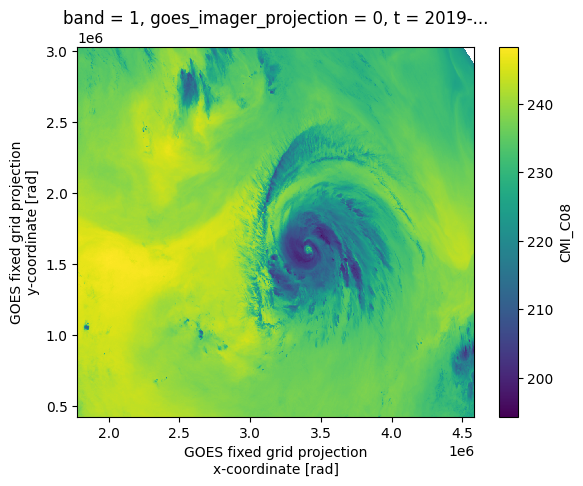

In [83]:
%%time
(
    goes_ds_gdal["CMI_C08"].isel(t=0)
    .plot.imshow()
)

## Using xarray.open_mfdataset with fsspec

`xarray.open_mfdataset` is the standard tool for loading the contents of multiple files into an xarray Dataset. You must use `fsspec` to open files directly from S3, however. This method is appealing because the time coordinates and scale/offset parameters will all get applied for you, but it is less intelligent about downloading targeted subsets of data and will eagerly download more data than the GDAL method. 

In [85]:
%%time

fs = fsspec.filesystem("s3", anon=True, client_kwargs=dict(region_name="us-east-1"))
files = [fs.open(f"s3://{bucket}/{goes_key}", cache_type="mmap") for goes_key in goes_keys]

goes_ds_mf = xr.open_mfdataset(
    files,
    chunks="auto",
    concat_dim="t",
    combine="nested",
    parallel=True,
    data_vars="minimal",
    coords="minimal",
    compat="override",
    join="exact",
)[variables].isel(x=slice(x0, x1), y=slice(y0, y1))

goes_ds_mf

CPU times: user 25.8 s, sys: 41.3 s, total: 1min 7s
Wall time: 3min 59s


<xarray.Dataset> Size: 349MB
Dimensions:  (t: 6, y: 1300, x: 1400)
Coordinates:
  * t        (t) datetime64[ns] 48B 2019-09-26T12:05:10.156957952 ... 2019-09...
  * y        (y) float32 5kB 0.08464 0.08459 0.08453 ... 0.01201 0.01196 0.0119
  * x        (x) float32 6kB 0.04976 0.04981 0.04987 ... 0.128 0.128 0.1281
    y_image  float32 4B ...
    x_image  float32 4B ...
Data variables:
    CMI_C08  (t, y, x) float32 44MB dask.array<chunksize=(1, 1300, 1400), meta=np.ndarray>
    CMI_C10  (t, y, x) float32 44MB dask.array<chunksize=(1, 1300, 1400), meta=np.ndarray>
    CMI_C13  (t, y, x) float32 44MB dask.array<chunksize=(1, 1300, 1400), meta=np.ndarray>
    CMI_C15  (t, y, x) float32 44MB dask.array<chunksize=(1, 1300, 1400), meta=np.ndarray>
    DQF_C08  (t, y, x) float32 44MB dask.array<chunksize=(1, 1300, 1400), meta=np.ndarray>
    DQF_C10  (t, y, x) float32 44MB dask.array<chunksize=(1, 1300, 1400), meta=np.ndarray>
    DQF_C13  (t, y, x) float32 44MB dask.array<chunksize=(1, 1300, 1400), meta=np.ndarray>
    DQF_C15  (t, y, x) float32 44MB dask.array<chunksize=(1, 1300, 1400), meta=np.ndarray>
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2019-09-26T12:10:06.5Z
    time_coverage_start:       2019-09-26T12:00:24.4Z
    time_coverage_end:         2019-09-26T12:09:55.8Z
    timeline_id:               ABI Mode 6
    production_data_source:    n/a
    id:                        3431652b-7861-44c3-a328-3c8a5116e59c

CPU times: user 281 ms, sys: 0 ns, total: 281 ms
Wall time: 247 ms


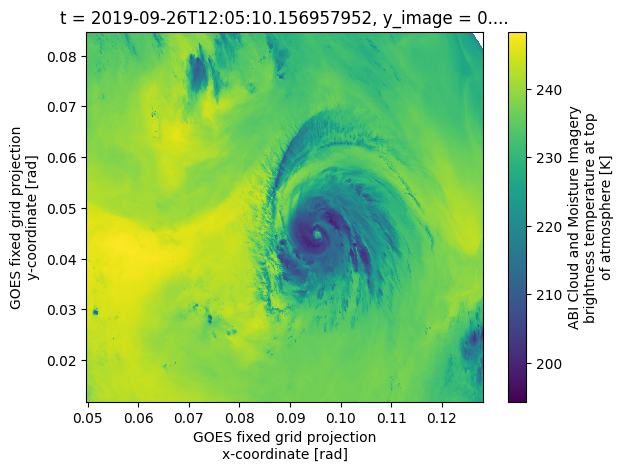

In [86]:
%%time
(
    goes_ds_mf["CMI_C08"].isel(t=0)
    .plot.imshow()
)